In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [30]:
def load_image(root_dir: str, dir_name: str, file_name: str, extension: str) -> Image:
    return Image.open(  # root_dir + dir_name + file_name + extension)
        os.path.join(
            root_dir,
            dir_name,
            file_name + extension
        )
    )

In [31]:
class CelebADataset(Dataset):
    def __init__(self, dir, transform=None):
        super().__init__()
        self.root = dir

        self.transform= transform

        self.list_of_inputs = os.listdir(dir)

    def __getitem__(self, idx):
        to_tensor_transform = transforms.ToTensor()

        image = load_image(self.root, r"", self.list_of_inputs[idx], "")
        image = to_tensor_transform(image)
    
        if self.transform:
            image = self.transform(image)
    
        return image.float()

    def __len__(self):
        return len(self.list_of_inputs)

In [32]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.Normalize(
    #    mean=[0.5, 0.5, 0.5],
    #    std=[0.25, 0.25, 0.25]
    #)
])

In [33]:
class GANGenerator(nn.Module):
    def __init__(self, latent_size=100, output_channels=3):
        super(GANGenerator, self).__init__()
        
        self.latent_size = latent_size
        
        self.generator = nn.Sequential(
            # in size: latent_size x 1 x 1

            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # size: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # size: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # size: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # size: 64 x 32 x 32
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # size: 64 x 32 x 32

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )
    
    def generate_noise(self, batch_size):
        return torch.randn(batch_size, self.latent_size, 1, 1) 
    
    def forward(self, noise):
        out = self.generator(noise)
        return out

In [34]:
class GANDiscriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(GANDiscriminator, self).__init__()
        
        self.discriminator = nn.Sequential(
            # in size: 3 x 64 x 64

            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(64), # it is unrecommended to use BatchNorm with gradient penalty
            nn.LeakyReLU(0.2, inplace=True),
            # size: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # size: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # size: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # size: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out size: 1 x 1 x 1

            nn.Flatten()
            # GAN discriminator with Wasserstein loss doesn't need sigmoid function in output, because it doesn't work with probabilities
        )
        
    def forward(self, x):
        out = self.discriminator(x)
        return out

In [35]:
class WassersteinLoss(nn.Module):
    def __init__(self):
        super(WassersteinLoss, self).__init__()
        
    def forward(self, outputs, targets):
        return -torch.mean(targets * outputs)

In [36]:
def gradient_penalty(discriminator, image_real, image_fake, device):
    t = torch.full(image_real.shape, np.random.rand(1)[0]).to(device)
    interpolation = t * image_real + (1 - t) * image_fake
    interpolation.requires_grad_()

    preds = discriminator(interpolation)
    grads = torch.autograd.grad(outputs=preds, inputs=interpolation,
                          grad_outputs=torch.ones_like(preds),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]

    gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()

    return gp

In [37]:
def fit(model, criterion, train_dl, device, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for iteration, real_images in enumerate(tqdm(train_dl), 0):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()
            
            real_images = real_images.to(device)

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.shape[0], 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = model["generator"].generate_noise(real_images.shape[0]).to(device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = -torch.ones(fake_images.shape[0], 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)
            gp = gradient_penalty(model["discriminator"], real_images, fake_images, device)
            
            # Update discriminator weights
            loss_d = real_loss + fake_loss + 0.2 * gp
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())
            

            # Train generator
            if iteration % 5 == 0:
                # Clear generator gradients
                optimizer["generator"].zero_grad()
            
                # Generate fake images
                latent = model["generator"].generate_noise(real_images.shape[0]).to(device)
                fake_images = model["generator"](latent)
            
                # Try to fool the discriminator
                preds = model["discriminator"](fake_images)
                targets = torch.ones(real_images.shape[0], 1, device=device)
                loss_g = criterion["generator"](preds, targets)
            
                # Update generator weights
                loss_g.backward()
                optimizer["generator"].step()
                loss_g_per_epoch.append(loss_g.item())
            
                losses_g.append(np.mean(loss_g_per_epoch))
                
        # Record losses & scores
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1])
        )
    
    return losses_g, losses_d, real_scores, fake_scores

In [38]:
batch_size_train = 64

In [39]:
train_dataset = CelebADataset(dir=r"celeba-dataset/img_align_celeba/img_align_celeba", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=16)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [41]:
model = {
    "discriminator": GANDiscriminator().to(device),
    "generator": GANGenerator(latent_size=500).to(device)
}

criterion = {
    "discriminator": WassersteinLoss(),
    "generator": WassersteinLoss()
}

In [ ]:
history = fit(model, criterion, train_dataloader, device, 10, 0.00005)

  0%|          | 0/3166 [00:00<?, ?it/s]

In [25]:
def draw_image(gen_image):
    gen_image = torch.transpose(gen_image, 3, 1)
    gen_image = torch.transpose(gen_image, 1, 2)
    gen_image = gen_image[0].detach().numpy()
    plt.imshow(gen_image)

In [26]:
noise = model['generator'].generate_noise(1)
noise = noise.to(device)
gen_image = model['generator'](noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


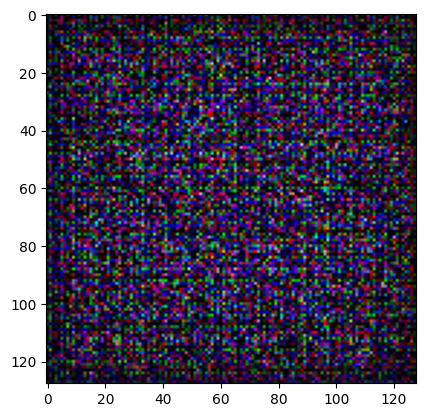

In [27]:
draw_image(gen_image.to(torch.device('cpu')))

In [28]:
gen_image.to(torch.device('cpu'))[0].detach().numpy()

array([[[-8.58476683e-02,  2.06574008e-01, -2.97221970e-02, ...,
          5.90075739e-02,  1.03007639e-02,  1.31395027e-01],
        [-1.50063500e-01, -1.51932538e-01, -7.85963163e-02, ...,
         -2.22633898e-01,  1.80701882e-01, -3.36238354e-01],
        [-1.42627716e-01,  3.08243006e-01,  2.27707282e-01, ...,
          1.32910535e-02,  1.95035517e-01,  5.38832787e-03],
        ...,
        [-1.81639299e-01, -1.04525931e-01, -4.07630950e-03, ...,
         -2.73461938e-01,  1.53101504e-01, -3.19347739e-01],
        [-2.73071453e-02,  1.74717844e-01,  1.04808889e-01, ...,
          3.63156408e-01, -2.14409038e-01,  9.60001349e-03],
        [-4.06013951e-02,  8.28070641e-02,  1.08062811e-02, ...,
         -8.75326544e-02,  1.42683059e-01, -1.67662099e-01]],

       [[ 4.32245508e-02,  5.80082051e-02, -1.60310045e-01, ...,
          1.13961101e-01, -8.93380344e-02,  8.00877213e-02],
        [ 7.17362389e-02,  1.29880235e-01, -5.45563042e-01, ...,
         -1.05759770e-01, -1.39156252e